### 1.Load and Prepare Dataset

Download dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sohrabbahari/ai-resume-screening-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\sohrabbahari\ai-resume-screening-dataset\versions\1


Check files

In [2]:
import os

print("Path to dataset files:", path)
print("Files in dataset folder:", os.listdir(path))


Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\sohrabbahari\ai-resume-screening-dataset\versions\1
Files in dataset folder: ['bert_model.pkl', 'cleaned_resumes.csv', 'Resume.csv']


Read dataset

In [3]:
import pandas as pd

csv_path = os.path.join(path, "cleaned_resumes.csv")
df = pd.read_csv(csv_path)
# print(df.head())
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              2484 non-null   int64 
 1   Resume_str      2484 non-null   object
 2   Resume_html     2484 non-null   object
 3   Category        2484 non-null   object
 4   Cleaned_Resume  2483 non-null   object
dtypes: int64(1), object(4)
memory usage: 97.2+ KB
None


Explore categories

In [4]:
print ("Displaying the distinct categories of resume:\n ")
print (df['Category'].unique())
print ("\nDisplaying the distinct categories of resume and the number of records belonging to each category:\n")
print (df['Category'].value_counts())

Displaying the distinct categories of resume:
 
['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' 'TEACHER' 'ADVOCATE'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES'
 'CONSULTANT' 'DIGITAL-MEDIA' 'AUTOMOBILE' 'CHEF' 'FINANCE' 'APPAREL'
 'ENGINEERING' 'ACCOUNTANT' 'CONSTRUCTION' 'PUBLIC-RELATIONS' 'BANKING'
 'ARTS' 'AVIATION']

Displaying the distinct categories of resume and the number of records belonging to each category:

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TE

Remove duplicates

In [5]:
df.duplicated(subset=['Cleaned_Resume']).value_counts()
cleaned_df = df.drop_duplicates(subset=['Cleaned_Resume'])
cleaned_df = cleaned_df.dropna(subset=['Cleaned_Resume', 'Category'])
print("Dataset shape before:", len(df))
print("Dataset shape after:", len(cleaned_df))

Dataset shape before: 2484
Dataset shape after: 2481


### 2. Train-test split (80/20)

In [6]:
from sklearn.model_selection import train_test_split
from collections import Counter

text = cleaned_df['Cleaned_Resume']
labels = cleaned_df['Category']

X_train_text, X_test_text, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")
print(f"Training label distribution: {Counter(y_train)}")
print(f"Test label distribution: {Counter(y_test)}")


Training set size: 1984
Test set size: 497
Training label distribution: Counter({'INFORMATION-TECHNOLOGY': 96, 'BUSINESS-DEVELOPMENT': 95, 'ACCOUNTANT': 94, 'ENGINEERING': 94, 'ADVOCATE': 94, 'CHEF': 94, 'FINANCE': 93, 'FITNESS': 93, 'SALES': 93, 'AVIATION': 93, 'HEALTHCARE': 92, 'BANKING': 92, 'CONSULTANT': 92, 'CONSTRUCTION': 90, 'PUBLIC-RELATIONS': 89, 'HR': 88, 'DESIGNER': 86, 'TEACHER': 82, 'ARTS': 82, 'APPAREL': 78, 'DIGITAL-MEDIA': 77, 'AGRICULTURE': 50, 'AUTOMOBILE': 29, 'BPO': 18})
Test label distribution: Counter({'FINANCE': 24, 'ADVOCATE': 24, 'INFORMATION-TECHNOLOGY': 24, 'ENGINEERING': 24, 'FITNESS': 24, 'CHEF': 24, 'BUSINESS-DEVELOPMENT': 24, 'ACCOUNTANT': 24, 'SALES': 23, 'CONSULTANT': 23, 'AVIATION': 23, 'HEALTHCARE': 23, 'BANKING': 23, 'HR': 22, 'CONSTRUCTION': 22, 'PUBLIC-RELATIONS': 22, 'DESIGNER': 21, 'ARTS': 21, 'TEACHER': 20, 'DIGITAL-MEDIA': 19, 'APPAREL': 19, 'AGRICULTURE': 13, 'AUTOMOBILE': 7, 'BPO': 4})


### 3. Preprocessing Data

In [7]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

def preprocess_resume(text):
    # Remove emails and URLs
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    
    # Replace numbers with placeholder
    text = re.sub(r'\d+', ' <NUM> ', text)
    
    # Keep letters, numbers, +, /, ., - 
    text = re.sub(r'[^a-zA-Z0-9\s\+\./-]', '', text)
    
    # Lowercase
    text = text.lower()
    
    # Tokenize (regex tokenizer preserves C++, Node.js, etc.)
    tokenizer = RegexpTokenizer(r'\b\w[\w\+\./-]*\b')
    tokens = tokenizer.tokenize(text)
    
    # Stopwords
    stop_words = set(stopwords.words('english'))
    custom_stopwords = ["would", "dont", "aaa"]
    stop_words.update(custom_stopwords)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return ' '.join(tokens)


# Preprocess training and test data separately
print("Preprocessing training data...")
X_train_processed = [preprocess_resume(text) for text in X_train_text]
print("\nPreprocessing training data completed!\n")

print("Preprocessing test data...")
X_test_processed = [preprocess_resume(text) for text in X_test_text]
print("\nPreprocessing test data completed!")

Preprocessing training data...

Preprocessing training data completed!

Preprocessing test data...

Preprocessing test data completed!


### 4. Feature Extraction (TF-IDF vs. Word2Vec vs. GloVe)

TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization with parameters tuned for sentiment analysis
tfidf_vectorizer = TfidfVectorizer(
    max_features=7000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95,
    stop_words='english',
    sublinear_tf=True
)


# Fit ONLY on training data, then transform both train and test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)
print("TF-IDF feature extraction completed.")

TF-IDF feature extraction completed.


Word2Vec (Skipgram model)

In [9]:
# Write code here

GloVe

In [10]:
# Write code here

### 5.1. Model Training (MultinomialNB)

TF-IDF

In [11]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes classifier
print("Training Naive Bayes classifier...")
classifier_tfidf_MNB = MultinomialNB(alpha=1.0)
classifier_tfidf_MNB.fit(X_train_tfidf, y_train)

print("Training completed!")
# print(classifier_tfidf.classes_)

# Show feature importance for each class
print("\nMost important words for each category:")
feature_names = tfidf_vectorizer.get_feature_names_out()
for i, class_name in enumerate(classifier_tfidf_MNB.classes_):
    top_features = classifier_tfidf_MNB.feature_log_prob_[i].argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_features]
    print(f"{class_name}: {', '.join(top_words[:5])}")

Training Naive Bayes classifier...
Training completed!

Most important words for each category:
ACCOUNTANT: accountant, accounting, reconciliation, financial, ledger
ADVOCATE: advocate, customer, service, patient, care
AGRICULTURE: agriculture, student, research, program, science
APPAREL: apparel, store, sale, merchandising, customer
ARTS: art, student, teacher, school, company city
AUTOMOBILE: automobile, customer, service, customer service, company city
AVIATION: aviation, aircraft, flight, maintenance, repair
BANKING: banking, loan, financial, bank, business
BPO: bpo, client, management, process, india
BUSINESS-DEVELOPMENT: business development, sale, business, marketing, development
CHEF: chef, food, kitchen, menu, culinary
CONSTRUCTION: construction, project, contractor, site, construction project
CONSULTANT: consultant, business, client, project, management
DESIGNER: designer, design, designer company, graphic, graphic designer
DIGITAL-MEDIA: digital, medium, marketing, social me

Word2Vec

In [12]:
# Write code here

GloVe

In [13]:
# Write code here

### 5.2 Model Training (Logistic Regression)

TF-IDF

In [14]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression classifier
print("\nTraining Logistic Regression classifier...")
classifier_tfidf_LR = LogisticRegression(
    random_state=42,
    max_iter=3000,          # Keep high for convergence
    C=0.5,                  # Regularization (lower C = stronger regularization)
    class_weight='balanced',# Critical due to label imbalance
    solver='saga',          # Works well for sparse matrices
)


classifier_tfidf_LR.fit(X_train_tfidf, y_train)

print("\nMost important words for each category:")
feature_names = tfidf_vectorizer.get_feature_names_out()
for i, class_name in enumerate(classifier_tfidf_LR.classes_):
    # coef_ shape: (n_classes, n_features)
    top_features = classifier_tfidf_LR.coef_[i].argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_features]
    print(f"{class_name}: {', '.join(top_words[:5])}")



Training Logistic Regression classifier...

Most important words for each category:
ACCOUNTANT: accountant, accounting, reconciliation, ledger, general ledger
ADVOCATE: advocate, patient, child, care, advocate summary
AGRICULTURE: agriculture, agricultural, student, soil, farmer
APPAREL: apparel, merchandising, store, fashion, merchandise
ARTS: art, art teacher, student, teacher, language art
AUTOMOBILE: automobile, claim, inquiry, auto, customer service
AVIATION: aviation, aircraft, flight, navy, maintenance
BANKING: banking, loan, bank, financial, mortgage
BPO: bpo, india, agent, escalation, like
BUSINESS-DEVELOPMENT: business development, development manager, sale, business, development
CHEF: chef, food, kitchen, menu, culinary
CONSTRUCTION: construction, construction project, contractor, construction manager, site
CONSULTANT: consultant, experience consultant, consultant summary, consulting, server
DESIGNER: designer, design, designer company, designer summary, graphic
DIGITAL-MED

Word2Vec

In [15]:
# Write code here

GloVe

In [16]:
# Write code here

### 6.1 Model Evaluation (MultinomialNB)

TF-IDF + MultinomialNB

Evaluating Naive Bayes Performance:
Cross-validation accuracy: 0.541
Overall Test Accuracy: 0.549 (54.9%)

Detailed Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.44      0.88      0.58        24
              ADVOCATE       0.30      0.38      0.33        24
           AGRICULTURE       1.00      0.08      0.14        13
               APPAREL       0.00      0.00      0.00        19
                  ARTS       1.00      0.10      0.17        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.83      0.65      0.73        23
               BANKING       0.78      0.61      0.68        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.42      0.88      0.57        24
                  CHEF       0.79      0.79      0.79        24
          CONSTRUCTION       0.65      0.68      0.67        22
            CONSULTANT      

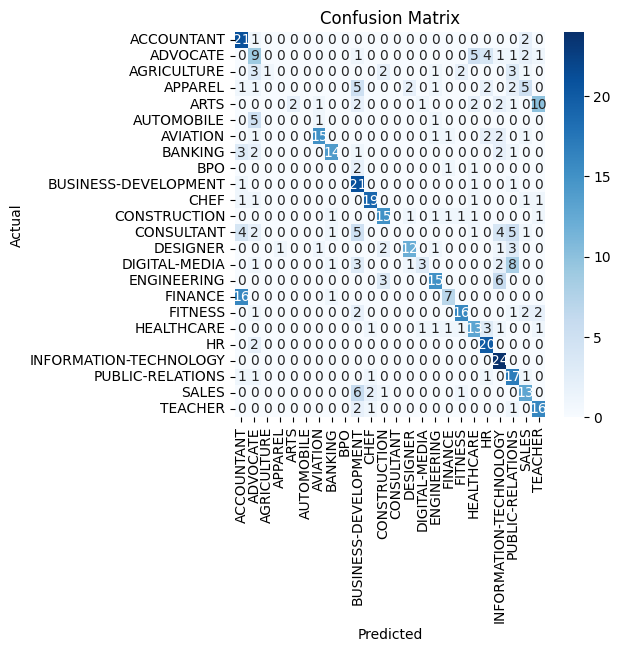

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate using cross-validation on training data
print("Evaluating Naive Bayes Performance:")
print("=" * 40)

cv_scores = cross_val_score(classifier_tfidf_MNB, X_train_tfidf, y_train, cv=3, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.3f}")
# print(f"Individual fold scores: {cv_scores}")

y_pred_MNB = classifier_tfidf_MNB.predict(X_test_tfidf)
# Calculate overall accuracy
accuracy_tfidf_MNB = accuracy_score(y_test, y_pred_MNB)
print(f"Overall Test Accuracy: {accuracy_tfidf_MNB:.3f} ({accuracy_tfidf_MNB*100:.1f}%)")

# Detailed report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_MNB, 
                          target_names=classifier_tfidf_MNB.classes_, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_MNB)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[name.split('.')[-1] for name in classifier_tfidf_MNB.classes_],
            yticklabels=[name.split('.')[-1] for name in classifier_tfidf_MNB.classes_])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Word2Vec + MultinomialNB

In [18]:
# Write code here

GloVe + MultinomialNB

In [19]:
# Write code here

### 6.2. Model Evaluation (Logistic Regression)

TF-IDF + Logistic Regression

Evaluating Logistic Regression Performance:
Cross-validation accuracy: 0.603
Overall Test Accuracy: 0.640 (64.0%)

Detailed Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.53      0.83      0.65        24
              ADVOCATE       0.47      0.38      0.42        24
           AGRICULTURE       0.70      0.54      0.61        13
               APPAREL       0.67      0.21      0.32        19
                  ARTS       0.57      0.19      0.29        21
            AUTOMOBILE       0.71      0.71      0.71         7
              AVIATION       0.85      0.74      0.79        23
               BANKING       0.94      0.65      0.77        23
                   BPO       1.00      0.25      0.40         4
  BUSINESS-DEVELOPMENT       0.54      0.88      0.67        24
                  CHEF       0.86      0.75      0.80        24
          CONSTRUCTION       0.74      0.77      0.76        22
            CONSULTA

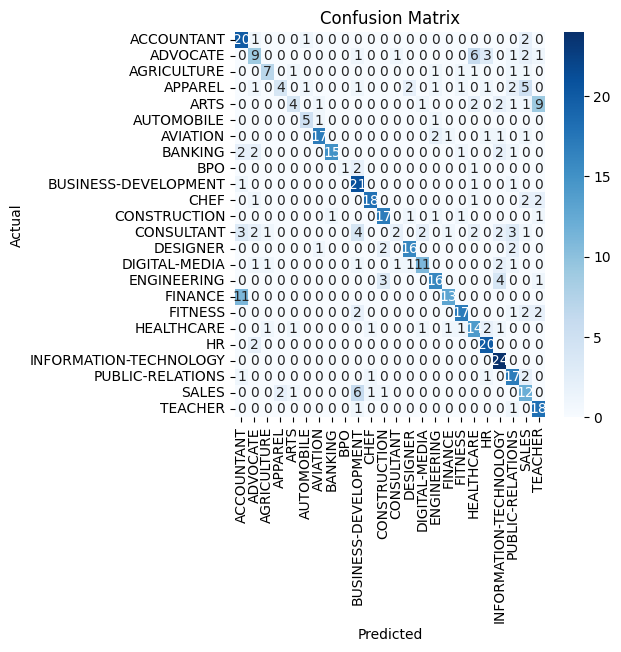

In [20]:
from sklearn.model_selection import cross_val_score

# Evaluate using cross-validation on training data
print("Evaluating Logistic Regression Performance:")
print("=" * 40)

cv_scores = cross_val_score(classifier_tfidf_LR, X_train_tfidf, y_train, cv=3, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.3f}")
# print(f"Individual fold scores: {cv_scores}")

y_pred_LR = classifier_tfidf_LR.predict(X_test_tfidf)
# Calculate overall accuracy
accuracy_tfidf_LR = accuracy_score(y_test, y_pred_LR)
print(f"Overall Test Accuracy: {accuracy_tfidf_LR:.3f} ({accuracy_tfidf_LR*100:.1f}%)")

# Detailed report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_LR, 
                          target_names=classifier_tfidf_LR.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_LR)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[name.split('.')[-1] for name in classifier_tfidf_LR.classes_],
            yticklabels=[name.split('.')[-1] for name in classifier_tfidf_LR.classes_])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Word2Vec + Logistic Regression

In [21]:
# Write code here

GloVe + Logistic Regression

In [22]:
# Write code here

### 7. Model Comparison

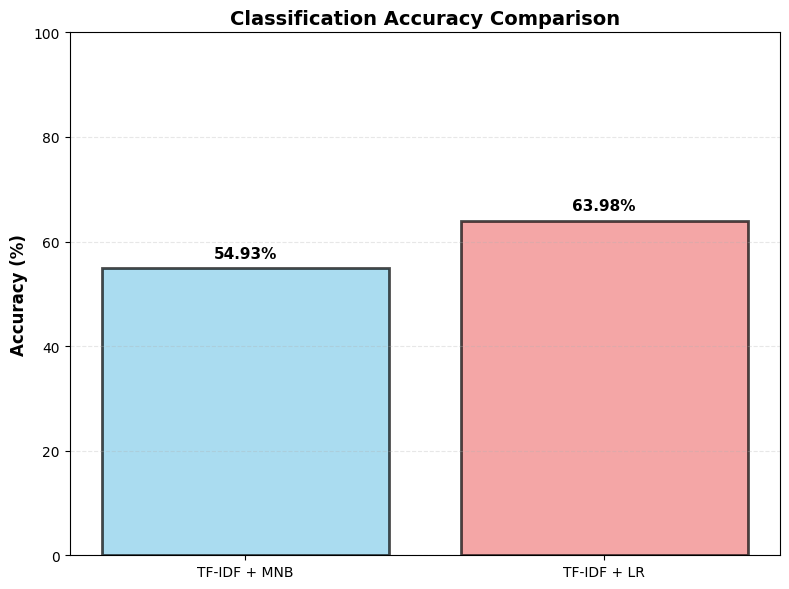

In [23]:
# # Visualize comprehensive comparison: TF-IDF vs Skip-gram vs CBOW vs GloVe
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # 1. Accuracy comparison
# methods = ['TF-IDF + MNB', 'TF-IDF + LR']
# accuracies = [accuracy_tfidf_MNB * 100, accuracy_tfidf_LR * 100]
# colors_bar = ['skyblue', 'lightcoral']

# axes[0].bar(methods, accuracies, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
# axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
# axes[0].set_title('Classification Accuracy Comparison', fontsize=14, fontweight='bold')
# axes[0].set_ylim([0, 100])
# axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# for i, v in enumerate(accuracies):
#     axes[0].text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold', fontsize=11)

# # 2. Dimensionality comparison
# # dimensions = [
# #     X_train_tfidf.shape[1],
# #     X_train_skipgram.shape[1],
# #     X_train_cbow.shape[1],
# #     X_train_glove.shape[1]
# # ]

# # axes[1].bar(methods, dimensions, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
# # axes[1].set_ylabel('Number of Dimensions', fontsize=12, fontweight='bold')
# # axes[1].set_title('Feature Dimensionality Comparison', fontsize=14, fontweight='bold')
# # axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# # for i, v in enumerate(dimensions):
# #     axes[1].text(i, v + max(dimensions)*0.02, f'{v:,}', ha='center', fontweight='bold', fontsize=11)

# plt.tight_layout()
# plt.show()

# Visualize comprehensive comparison: TF-IDF vs Skip-gram vs CBOW vs GloVe
fig, ax = plt.subplots(figsize=(8, 6))

# 1. Accuracy comparison
methods = ['TF-IDF + MNB', 'TF-IDF + LR']
accuracies = [accuracy_tfidf_MNB * 100, accuracy_tfidf_LR * 100]
colors_bar = ['skyblue', 'lightcoral']

ax.bar(methods, accuracies, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Classification Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3, linestyle='--')

for i, v in enumerate(accuracies):
    ax.text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()



### 8.1. Making Predictions (MultinomialNB)

TF-IDF + MultinomialNB

In [24]:
# Test with some examples from test set
# import numpy as np
# sample_size = 5
# sample_indices = np.random.choice(len(X_test_processed), sample_size, replace=False)

# Process test data
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

# Make predictions
probabilities = classifier_tfidf_MNB.predict_proba(X_test_tfidf)

# Show results for first 5 test samples
for i in range(5):
    actual_category = y_test.iloc[i]        # get the actual label directly
    predicted_category = y_pred_MNB[i]      # already a string
    confidence = probabilities[i].max()     # max probability

    print(f"Article {i+1}:")
    print(f"Text: {X_test_text.iloc[i][:100]}...")
    print(f"Actual: {actual_category}")
    print(f"Predicted: {predicted_category} (confidence: {confidence:.3f})")
    print(f"Correct: {'✓' if actual_category == predicted_category else '✗'}")
    print("-" * 50)


Article 1:
Text: chief digital officer summary highly motivated versatile digital strategist storyteller creative ena...
Actual: DIGITAL-MEDIA
Predicted: DIGITAL-MEDIA (confidence: 0.356)
Correct: ✓
--------------------------------------------------
Article 2:
Text: hr representative summary experienced human resources professional working knowledge state federal e...
Actual: HR
Predicted: HR (confidence: 0.707)
Correct: ✓
--------------------------------------------------
Article 3:
Text: guest teacher professional overview detail oriented high energy social science teacher ability motiv...
Actual: TEACHER
Predicted: BUSINESS-DEVELOPMENT (confidence: 0.123)
Correct: ✗
--------------------------------------------------
Article 4:
Text: sales director summary continue career organization utilize management supervision administrative sk...
Actual: SALES
Predicted: BUSINESS-DEVELOPMENT (confidence: 0.140)
Correct: ✗
--------------------------------------------------
Article 5:
Text: consu

Word2Vec + MultinomialNB

In [25]:
# Write code here

GloVe + MultinomialNB

In [26]:
# Write code here

### 8.2. Making Predictions (Logistic Regression)

TF-IDF + Logistic Regression

In [27]:
# Test with some examples from test set
# Process test data
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

# Make predictions
probabilities = classifier_tfidf_LR.predict_proba(X_test_tfidf)

# Show results for first 5 test samples
for i in range(5):
    actual_category = y_test.iloc[i]        # get the actual label directly
    predicted_category = y_pred_LR[i]      # already a string
    confidence = probabilities[i].max()     # max probability

    print(f"Article {i+1}:")
    print(f"Text: {X_test_text.iloc[i][:100]}...")
    print(f"Actual: {actual_category}")
    print(f"Predicted: {predicted_category} (confidence: {confidence:.3f})")
    print(f"Correct: {'✓' if actual_category == predicted_category else '✗'}")
    print("-" * 50)


Article 1:
Text: chief digital officer summary highly motivated versatile digital strategist storyteller creative ena...
Actual: DIGITAL-MEDIA
Predicted: DIGITAL-MEDIA (confidence: 0.286)
Correct: ✓
--------------------------------------------------
Article 2:
Text: hr representative summary experienced human resources professional working knowledge state federal e...
Actual: HR
Predicted: HR (confidence: 0.293)
Correct: ✓
--------------------------------------------------
Article 3:
Text: guest teacher professional overview detail oriented high energy social science teacher ability motiv...
Actual: TEACHER
Predicted: TEACHER (confidence: 0.092)
Correct: ✓
--------------------------------------------------
Article 4:
Text: sales director summary continue career organization utilize management supervision administrative sk...
Actual: SALES
Predicted: BUSINESS-DEVELOPMENT (confidence: 0.072)
Correct: ✗
--------------------------------------------------
Article 5:
Text: consultant profess

Word2Vec + Logistic Regression

In [28]:
# Write code here

GloVe + Logistic Regression

In [29]:
# Write code here

Save models

In [30]:
# import pickle

# # Save TF-IDF vectorizer
# with open('tfidf_vectorizer.pkl', 'wb') as f:
#     pickle.dump(tfidf_vectorizer, f)

# # Save Multinomial Naive Bayes model
# with open('classifier_tfidf_mnb.pkl', 'wb') as f:
#     pickle.dump(classifier_tfidf_MNB, f)

# # Save Logistic Regression model
# with open('classifier_tfidf_lr.pkl', 'wb') as f:
#     pickle.dump(classifier_tfidf_LR, f)

### 9. Skills and Relationship Extraction

In [31]:
# !python -m spacy download en_core_web_lg


In [32]:
import spacy
import re
from collections import Counter

# Load spaCy model
nlp = spacy.load("en_core_web_lg")

# Comprehensive known companies whitelist
KNOWN_COMPANIES = {
    "amazon", "microsoft", "google", "facebook", "meta", "apple", "netflix", "tesla",
    "walmart", "target", "costco", "starbucks", "mcdonald's", "mcdonalds", "disney", 
    "coca-cola", "pepsi", "pepsico", "ibm", "oracle", "adobe", "salesforce", "uber", 
    "airbnb", "linkedin", "twitter", "ebay", "paypal", "visa", "mastercard", "amex",
    "boeing", "ge", "general electric", "ford", "toyota", "honda", "nike", "adidas",
    "mgm", "hilton", "marriott", "hyatt", "intercontinental",
    "henkel", "unilever", "procter & gamble", "p&g", "johnson & johnson",
    "pfizer", "merck", "abbvie", "bristol myers", "eli lilly",
    "cnn", "nbc", "abc", "cbs", "fox", "espn", "hbo", "msnbc", "techtv",
    "dentsu", "aegis", "omnicom", "wpp", "publicis", "havas",
    "caesars", "elizabeth arden", "remington", "allergan",
    "gaylord", "lesueur", "michael foods", "wavefly", "jmf solutions",
    "sysco", "aramark", "sodexo", "compass group", "jpmorgan", "wells fargo",
    "bank of america", "citigroup", "goldman sachs", "morgan stanley",
    "accenture", "deloitte", "pwc", "kpmg", "ey", "mckinsey", "bain", "bcg"
}

# Definite NOT companies (software, cities, programs, etc.)
NOT_COMPANIES = {
    # Software/Tools
    "kronos", "ulti pro", "ultipro", "workday", "adp", "sap", "oracle", "salesforce crm",
    "microsoft office", "ms office", "excel", "powerpoint", "word", "outlook",
    "photoshop", "illustrator", "indesign", "adobe suite",
    # Government programs
    "medicare", "medicaid", "social security", "osha", "ada", "fmla", "cobra",
    # Cities (common ones in resumes)
    "chaska", "minneapolis", "chicago", "seattle", "new york", "san francisco",
    "boston", "atlanta", "dallas", "houston", "phoenix", "denver",
    # Generic terms
    "state", "city", "county", "department", "agency", "commission",
    # Education
    "university", "college", "school", "institute"
}

def is_definitely_not_company(text):
    """Check if text is definitely NOT a company."""
    text_lower = text.lower().strip()
    
    # Check NOT_COMPANIES list
    if text_lower in NOT_COMPANIES:
        return True
    
    # Check if it contains software/tool names
    software_indicators = ["office", "excel", "word", "powerpoint", "outlook", "kronos", "ulti"]
    if any(sw in text_lower for sw in software_indicators):
        return True
    
    # Check if it contains education indicators
    edu_indicators = ["university", "college", "school", "institute", "academy"]
    if any(edu in text_lower for edu in edu_indicators):
        return True
    
    # Check if it contains location indicators
    location_indicators = ["city", "state", "county", "street", "avenue", "road"]
    if any(loc in text_lower for loc in location_indicators):
        return True
    
    return False

def is_likely_company(text):
    """Check if text is likely a company name."""
    text_lower = text.lower().strip()
    
    # Whitelist check
    if text_lower in KNOWN_COMPANIES:
        return True
    
    # Definitely not a company
    if is_definitely_not_company(text):
        return False
    
    # Must be reasonable length
    if len(text) < 2 or len(text) > 50:
        return False
    
    # Single character or very short
    if len(text) <= 2:
        return False
    
    # All caps short acronyms (unless whitelisted)
    if text.isupper() and len(text) <= 3:
        return False
    
    # Must start with capital or number
    if not (text[0].isupper() or text[0].isdigit()):
        return False
    
    # If it's 2+ capitalized words, probably a company
    words = text.split()
    if len(words) >= 2:
        cap_words = [w for w in words if w[0].isupper()]
        if len(cap_words) >= 2:
            return True
    
    # Single word that's capitalized and reasonable length
    if len(words) == 1 and len(text) >= 4:
        return True
    
    return False

def extract_job_org_relations(text):
    """
    Multi-strategy extraction that handles various resume formats.
    """
    relations = []
    seen_companies = set()
    
    # Strategy 1: Explicit patterns with job titles
    # Patterns like "Senior HR Manager at Company Name" or "worked as X at Y"
    patterns = [
        r"(?:worked|served|employed|hired)\s+(?:as\s+)?([^,.\n]{5,50}?)\s+(?:at|for|with)\s+([A-Z][a-zA-Z\s&.''-]+?)(?:\s|,|\.|$)",
        r"([A-Z][a-zA-Z\s]+(?:manager|director|analyst|engineer|developer|designer|specialist|coordinator|consultant|representative|officer|supervisor|lead|architect))\s+(?:at|for|with)\s+([A-Z][a-zA-Z\s&.''-]+?)(?:\s|,|\.|$)",
    ]
    
    for pattern in patterns:
        for match in re.finditer(pattern, text, re.IGNORECASE):
            job_title = match.group(1).strip()
            company = match.group(2).strip()
            
            # Clean company name
            company = re.split(r'\s+(?:in|from|since|during|-)', company)[0].strip()
            
            if is_likely_company(company) and company.lower() not in seen_companies:
                relations.append(f"{job_title.title()} at {company.title()}")
                seen_companies.add(company.lower())
    
    # Strategy 2: Look for whitelisted companies anywhere in text
    for known_company in KNOWN_COMPANIES:
        if known_company.lower() in seen_companies:
            continue
        
        # Case-insensitive search
        pattern = r'\b' + re.escape(known_company) + r'\b'
        if re.search(pattern, text, re.IGNORECASE):
            # Check if it's in a work context (within 150 chars of work keywords)
            matches = list(re.finditer(pattern, text, re.IGNORECASE))
            for match in matches:
                start = max(0, match.start() - 150)
                end = min(len(text), match.end() + 150)
                context = text[start:end].lower()
                
                work_keywords = [
                    'work', 'employ', 'position', 'role', 'experience', 
                    'company', 'organization', 'corporation', 'firm',
                    'managed', 'led', 'developed', 'responsible', 'duties'
                ]
                
                if any(kw in context for kw in work_keywords):
                    relations.append(f"Experience at {known_company.title()}")
                    seen_companies.add(known_company.lower())
                    break
    
    # Strategy 3: Use spaCy but with very strict filtering
    doc = nlp(text)
    
    for ent in doc.ents:
        if ent.label_ != "ORG":
            continue
        
        if ent.text.lower() in seen_companies:
            continue
        
        if not is_likely_company(ent.text):
            continue
        
        # Check work context in the sentence
        sent = ent.sent.text.lower()
        work_indicators = [
            'work', 'employ', 'position', 'role', 'experience', 
            'responsibilities', 'duties', 'managed', 'led', 'developed'
        ]
        
        if any(indicator in sent for indicator in work_indicators):
            relations.append(f"Experience at {ent.text.title()}")
            seen_companies.add(ent.text.lower())
    
    # Strategy 4: Last resort - look for capitalized 2-3 word phrases in work sections
    # This helps when the resume has company names but spaCy missed them
    work_section_pattern = r'(?:experience|employment|work history|professional background)[:\s]+([^\.]+?)(?:education|skills|certifications|$)'
    work_sections = re.findall(work_section_pattern, text, re.IGNORECASE | re.DOTALL)
    
    for section in work_sections:
        # Find capitalized multi-word phrases
        cap_phrases = re.findall(r'\b[A-Z][a-z]+\s+[A-Z][a-z]+(?:\s+[A-Z][a-z]+)?\b', section)
        
        for phrase in cap_phrases:
            if phrase.lower() in seen_companies:
                continue
            
            if is_likely_company(phrase):
                relations.append(f"Experience at {phrase.title()}")
                seen_companies.add(phrase.lower())
    
    return relations if relations else ["No clear job-org relationships found"]

# Skills extraction
skills_pool = {
    "HR": ["recruitment", "interviewing", "onboarding", "employee relations", "hr policies",
           "payroll", "talent acquisition", "performance management", "training", "benefits administration"],
    "DESIGNER": ["photoshop", "illustrator", "figma", "adobe xd", "ui design", "ux design", "wireframing",
                 "logo design", "graphic design", "typography", "prototyping", "creativity"],
    "INFORMATION-TECHNOLOGY": ["python", "java", "c++", "c#", "javascript", "react", "node.js", "sql", "html", "css",
                                "typescript", "flask", "django", "spring", "software development", "data analysis",
                                "machine learning", "ai", "pandas", "numpy", "git"],
    "TEACHER": ["lesson planning", "curriculum development", "classroom management", "grading",
                "student engagement", "communication", "mentoring", "public speaking", "education technology"],
    "ADVOCATE": ["legal research", "drafting", "litigation", "contracts", "compliance", "corporate law",
                 "intellectual property", "negotiation", "case management", "advocacy"],
    "BUSINESS-DEVELOPMENT": ["sales strategy", "client relations", "market research", "partnerships", "lead generation",
                             "b2b", "crm", "pipeline management", "business strategy", "negotiation"],
    "HEALTHCARE": ["patient care", "diagnosis", "medical records", "phlebotomy", "emergency response",
                   "clinical procedures", "first aid", "surgery assistance", "public health", "pharmacology"],
    "FITNESS": ["personal training", "nutrition", "fitness assessment", "strength training", "cardio",
                "injury prevention", "yoga", "exercise programming", "motivation", "client coaching"],
    "AGRICULTURE": ["crop management", "soil science", "irrigation", "harvesting", "farm equipment",
                    "organic farming", "agribusiness", "animal husbandry", "pesticide control", "planting"],
    "BPO": ["customer service", "inbound calls", "outbound calls", "ticketing", "crm software",
            "technical support", "communication", "time management", "problem solving", "escalation handling"],
    "SALES": ["sales strategy", "lead generation", "customer relationship management", "negotiation",
              "closing deals", "cold calling", "presentation", "sales forecasting", "upselling", "crm"],
    "CONSULTANT": ["business analysis", "project management", "strategy", "stakeholder management",
                   "data analysis", "presentation", "problem solving", "process improvement"],
    "DIGITAL-MEDIA": ["social media", "seo", "content creation", "copywriting", "google ads", "facebook ads",
                      "email marketing", "campaign management", "analytics", "branding"],
    "AUTOMOBILE": ["vehicle maintenance", "mechanical repair", "diagnostics", "automotive systems",
                   "engine tuning", "electrical systems", "safety inspection", "parts replacement"],
    "CHEF": ["cooking", "menu planning", "food safety", "recipe development", "plating", "baking",
             "inventory management", "teamwork", "sanitation", "knife skills"],
    "FINANCE": ["accounting", "budgeting", "financial analysis", "investment", "forecasting", "auditing",
                "taxation", "risk management", "bookkeeping", "excel", "financial modeling"],
    "APPAREL": ["fashion design", "textile", "sewing", "pattern making", "trend analysis", "styling",
                "merchandising", "fabric selection", "retail management"],
    "ENGINEERING": ["autocad", "solidworks", "matlab", "design analysis", "project management", "mechanical systems",
                    "civil design", "electrical circuits", "simulation", "blueprint reading"],
    "ACCOUNTANT": ["bookkeeping", "financial reporting", "tax preparation", "auditing", "reconciliation",
                   "payroll", "excel", "budgeting", "financial statements", "accounting software"],
    "CONSTRUCTION": ["site supervision", "blueprint reading", "safety management", "quantity surveying",
                     "project scheduling", "civil works", "materials management", "contract management"],
    "PUBLIC-RELATIONS": ["media relations", "press release", "branding", "crisis communication", "copywriting",
                         "public speaking", "event coordination", "marketing communication"],
    "BANKING": ["customer service", "loan processing", "credit analysis", "cash handling",
                "financial advisory", "branch operations", "risk assessment", "compliance"],
    "ARTS": ["painting", "drawing", "illustration", "creative writing", "music composition",
             "photography", "editing", "storytelling", "animation", "art direction"],
    "AVIATION": ["flight operations", "navigation", "safety procedures", "aircraft maintenance",
                 "air traffic communication", "crew management", "aviation regulations"]
}

def extract_skills(text, skills_pool):
    """Extract skills from text."""
    text_lower = text.lower()
    extracted_skills = []
    
    for skill in {s.lower() for v in skills_pool.values() for s in v}:
        if re.search(r"\b" + re.escape(skill) + r"\b", text_lower):
            extracted_skills.append(skill)
    
    skills_by_domain = {domain: [] for domain in skills_pool}
    for skill in extracted_skills:
        for domain, skill_list in skills_pool.items():
            if skill.lower() in [s.lower() for s in skill_list]:
                skills_by_domain[domain].append(skill.capitalize())
                break
    
    return skills_by_domain

# Example usage
for i in range(5):
    text = X_test_text.iloc[i]
    
    job_org_relations = extract_job_org_relations(text)
    skills_by_domain = extract_skills(text, skills_pool)
    
    print(f"\n--- Resume {i+1} ---")
    print("\n=== JOB → ORG Relations ===")
    for relation in job_org_relations:
        print(relation)
    
    print("\n=== Skills Extracted ===")
    for domain, skills in skills_by_domain.items():
        if skills:
            print(f"{domain}: {', '.join(skills)}")


--- Resume 1 ---

=== JOB → ORG Relations ===
Experience at Dentsu
Experience at Disney
Experience at Walmart
Experience at Remington
Experience at Aegis
Experience at Hilton
Experience at Allergan
Experience at Henkel
Experience at Elizabeth Arden
Experience at Starbucks
Experience at Cnn
Experience at Msnbc

=== Skills Extracted ===
TEACHER: Mentoring
BUSINESS-DEVELOPMENT: Crm
CONSULTANT: Strategy
DIGITAL-MEDIA: Content creation, Analytics, Social media, Seo, Branding

--- Resume 2 ---

=== JOB → ORG Relations ===
Experience at Michael Foods
Experience at Lesueur
Experience at Gaylord

=== Skills Extracted ===
HR: Recruitment, Payroll, Training, Employee relations
TEACHER: Communication
HEALTHCARE: First aid
BPO: Customer service
CHEF: Food safety

--- Resume 3 ---

=== JOB → ORG Relations ===
Experience at Intercontinental
Experience at Hilton
Experience at Mgm
Experience at Starbucks
Experience at Caesars

=== Skills Extracted ===
INFORMATION-TECHNOLOGY: Html
TEACHER: Communicatio

In [33]:
# # app.py
# from flask import Flask, render_template, request, jsonify
# import PyPDF2
# import pickle
# import re
# from nltk.corpus import stopwords
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem import WordNetLemmatizer
# import spacy
# import os
# import io

# app = Flask(__name__)
# app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024  # 16MB max

# # Load spaCy model

# tfidf_vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))
# classifier_mnb = pickle.load(open('classifier_tfidf_mnb.pkl', 'rb'))
# classifier_lr = pickle.load(open('classifier_tfidf_lr.pkl', 'rb'))


# def extract_text_from_pdf(pdf_file):
#     """Extract text from PDF."""
#     try:
#         pdf_reader = PyPDF2.PdfReader(pdf_file)
#         text = ""
#         for page in pdf_reader.pages:
#             text += page.extract_text()
#         return text
#     except Exception as e:
#         return None

# @app.route('/')
# def index():
#     return render_template('/templates/index.html')

# @app.route('/analyze', methods=['POST'])
# def analyze():
#     if 'resume' not in request.files:
#         return jsonify({'error': 'No file uploaded'}), 400
    
#     file = request.files['resume']
#     model_choice = request.form.get('model', 'mnb')
    
#     if file.filename == '':
#         return jsonify({'error': 'No file selected'}), 400
    
#     if not file.filename.endswith('.pdf'):
#         return jsonify({'error': 'Please upload a PDF file'}), 400
    
#     # Extract text from PDF
#     text = extract_text_from_pdf(file)
#     if not text:
#         return jsonify({'error': 'Could not extract text from PDF'}), 400
    
#     # Preprocess
#     processed_text = preprocess_resume(text)
    
#     # Vectorize
#     text_tfidf = tfidf_vectorizer.transform([processed_text])
    
#     # Predict based on model choice
#     if model_choice == 'mnb':
#         prediction = classifier_mnb.predict(text_tfidf)[0]
#         probabilities = classifier_mnb.predict_proba(text_tfidf)[0]
#         model_name = "Multinomial Naive Bayes"
#     else:
#         prediction = classifier_lr.predict(text_tfidf)[0]
#         probabilities = classifier_lr.predict_proba(text_tfidf)[0]
#         model_name = "Logistic Regression"
    
#     # Get top 3 predictions with probabilities
#     classes = classifier_mnb.classes_ if model_choice == 'mnb' else classifier_lr.classes_
#     top_3_indices = probabilities.argsort()[-3:][::-1]
#     top_predictions = [
#         {
#             'category': classes[idx],
#             'confidence': float(probabilities[idx] * 100)
#         }
#         for idx in top_3_indices
#     ]
    
#     # Extract skills and job-org relations
#     skills = extract_skills(text)
#     job_orgs = extract_job_org_relations(text)
    
#     return jsonify({
#         'model': model_name,
#         'prediction': prediction,
#         'confidence': float(max(probabilities) * 100),
#         'top_predictions': top_predictions,
#         'skills': skills,
#         'job_org_relations': job_orgs,
#         'text_preview': text[:500] + '...' if len(text) > 500 else text
#     })

# if __name__ == '__main__':
#     app.run(debug=True)